In [ ]:
# task5
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.utils.data as data

# ---------- Helper: Geo ----------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = np.radians(lat1), np.radians(lat2)
    dlat = p2 - p1
    dlon = np.radians(lon2) - np.radians(lon1)
    a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(np.maximum(a, 0)))

# ---------- Helper: Feature Eng. ----------
def add_trend_feats(df, base):
    cols = [f"{base}_{i}" for i in [1,2,3,4] if f"{base}_{i}" in df.columns]
    if len(cols) < 2: return df
    x = df[cols].astype(float)
    df[f"{base}_mean"] = x.mean(axis=1)
    df[f"{base}_std"]  = x.std(axis=1)
    df[f"{base}_cv"]   = (df[f"{base}_std"]/(x.mean(axis=1).abs()+1e-6))
    df[f"{base}_delta14"] = x[cols[-1]]-x[cols[0]]
    t = np.arange(1, len(cols)+1, dtype=float)
    t_c = t-t.mean()
    df[f"{base}_slope"] = np.sum(x.values*t_c, axis=1)/(np.sum(t_c**2)+1e-6)
    return df

def add_geo_feats(df):
    for i in [1,2,3]:
        la1,lo1,la2,lo2=f"login_lat_{i}",f"login_lon_{i}",f"login_lat_{i+1}",f"login_lon_{i+1}"
        if all(c in df.columns for c in [la1,lo1,la2,lo2]):
            df[f"login_dist_{i}{i+1}"]=haversine(df[la1],df[lo1],df[la2],df[lo2])
    dcols=[c for c in df.columns if c.startswith("login_dist_")]
    if dcols:
        df["login_dist_max"]=df[dcols].max(axis=1)
        df["login_dist_sum"]=df[dcols].sum(axis=1)
    return df

def winsorize_df(df,p=0.01):
    out=df.copy()
    for c in out.columns:
        if pd.api.types.is_numeric_dtype(out[c]):
            lo,hi=out[c].quantile(p),out[c].quantile(1-p)
            out[c]=out[c].clip(lo,hi)
    return out

def rankify(a): return pd.Series(a).rank(method="average").values

# ---------- Paths ----------
ROOT=Path(".")
TASK_DIR=ROOT/"task5"
TEST_PATH=TASK_DIR/"test.csv"
OUT_DIR=TASK_DIR/"submissions"
OUT_DIR.mkdir(exist_ok=True,parents=True)

# ---------- Load ----------
df=pd.read_csv(TEST_PATH)
id_vals=df["id"].astype(str).values
drop_cols=[c for c in ["id","player_id"] if c in df.columns]
X=df.drop(columns=drop_cols,errors="ignore").copy()
for c in X.columns:
    if X[c].dtype=="object":
        X[c]=pd.to_numeric(X[c],errors="coerce")

# ---------- Feature Eng ----------
bases={c[:-2] for c in X.columns if c.endswith(("_1","_2","_3","_4"))}
for b in bases: X=add_trend_feats(X,b)
X=add_geo_feats(X)
X=X.replace([np.inf,-np.inf],np.nan).fillna(X.median(numeric_only=True))
X=winsorize_df(X,p=0.01)
scaler=RobustScaler(); Xs=scaler.fit_transform(X)

# ---------- Isolation Forest / OCSVM / LOF ----------
IF=IsolationForest(n_estimators=700,max_samples="auto",bootstrap=True,
                   random_state=42,n_jobs=-1,contamination="auto")
IF.fit(Xs); s_if=-IF.score_samples(Xs)
OC=OneClassSVM(kernel="rbf",gamma="scale",nu=0.05)
OC.fit(Xs); s_oc=-OC.score_samples(Xs)
LOF=LocalOutlierFactor(n_neighbors=35,contamination=0.05,novelty=True)
LOF.fit(Xs); s_lof=-LOF.score_samples(Xs)

# ---------- Autoencoder ----------
class AE(nn.Module):
    def __init__(self,in_dim,h=128):
        super().__init__()
        self.enc=nn.Sequential(nn.Linear(in_dim,h),nn.ReLU(),nn.Linear(h,h//2),nn.ReLU())
        self.dec=nn.Sequential(nn.Linear(h//2,h),nn.ReLU(),nn.Linear(h,in_dim))
    def forward(self,x): return self.dec(self.enc(x))

device="cuda" if torch.cuda.is_available() else "cpu"
in_dim=Xs.shape[1]
ae=AE(in_dim).to(device)
opt=torch.optim.Adam(ae.parameters(),lr=1e-3)
crit=nn.MSELoss()
loader=data.DataLoader(torch.tensor(Xs,dtype=torch.float32),batch_size=256,shuffle=True)
for epoch in range(5):  # 5 epochs เร็วพอ
    ae.train(); total=0
    for batch in loader:
        batch=batch.to(device)
        opt.zero_grad(); out=ae(batch)
        loss=crit(out,batch); loss.backward(); opt.step()
        total+=loss.item()
    print(f"AE epoch {epoch+1}: loss={total/len(loader):.5f}")

ae.eval()
with torch.no_grad():
    tX=torch.tensor(Xs,dtype=torch.float32).to(device)
    recon=ae(tX)
    loss=((recon-tX)**2).mean(dim=1).cpu().numpy()
score_ae=(loss-loss.min())/(loss.max()-loss.min()+1e-9)

# ---------- Ensemble (4 โมเดล) ----------
r_if=rankify(s_if); r_oc=rankify(s_oc); r_lof=rankify(s_lof); r_ae=rankify(score_ae)
score_ens=(r_if+r_oc+r_lof+r_ae)/4.0

# ---------- Calibration ----------
q_hi,q_lo=0.05,0.75
hi_thr,lo_thr=np.quantile(score_ens,1-q_hi),np.quantile(score_ens,q_lo)
pseudo_y=np.full(len(score_ens),np.nan)
pseudo_y[score_ens>=hi_thr]=1; pseudo_y[score_ens<=lo_thr]=0
mask=~np.isnan(pseudo_y)
if mask.sum()>100:
    calib=LogisticRegression(max_iter=1000)
    calib.fit(score_ens[mask].reshape(-1,1),pseudo_y[mask])
    p_anom=calib.predict_proba(score_ens.reshape(-1,1))[:,1]
else:
    mn,mx=score_ens.min(),score_ens.max()
    p_anom=(score_ens-mn)/(mx-mn+1e-9)

# ---------- ทำหลาย target_rate ----------
target_rates=[0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
order=np.argsort(-p_anom)
for rate in target_rates:
    k=max(1,int(rate*len(p_anom)))
    pred=np.zeros(len(p_anom),dtype=int)
    pred[order[:k]]=1
    sub=pd.DataFrame({"id":id_vals,"task5":pred})
    out_file=OUT_DIR/f"task5_pred_rate{int(rate*100):02d}.csv"
    sub.to_csv(out_file,index=False)
    print(f"[OK] wrote {out_file}  (rate={rate:.2f}, anomalies={pred.sum()})")


C:\Users\Admin\AppData\Local\Temp\ipykernel_23948\1857257723.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base}_slope"] = np.sum(x.values*t_c, axis=1)/(np.sum(t_c**2)+1e-6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23948\1857257723.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base}_mean"] = x.mean(axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23948\1857257723.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

AE epoch 1: loss=106591826.31947
AE epoch 2: loss=72441.75089
AE epoch 3: loss=7881.14734
AE epoch 4: loss=13589.56479
AE epoch 5: loss=109440.85233
[OK] wrote task5\submissions\task5_pred_rate03.csv  (rate=0.03, anomalies=776)
[OK] wrote task5\submissions\task5_pred_rate04.csv  (rate=0.04, anomalies=1035)
[OK] wrote task5\submissions\task5_pred_rate05.csv  (rate=0.05, anomalies=1294)
[OK] wrote task5\submissions\task5_pred_rate06.csv  (rate=0.06, anomalies=1553)
[OK] wrote task5\submissions\task5_pred_rate07.csv  (rate=0.07, anomalies=1812)
[OK] wrote task5\submissions\task5_pred_rate08.csv  (rate=0.08, anomalies=2071)
[OK] wrote task5\submissions\task5_pred_rate09.csv  (rate=0.09, anomalies=2330)
[OK] wrote task5\submissions\task5_pred_rate10.csv  (rate=0.10, anomalies=2588)


In [ ]:
from sklearn.metrics import fbeta_score

# --- สร้าง pseudo-label จาก ensemble score ---
q_hi, q_lo = 0.05, 0.75
hi_thr = np.quantile(score_ens, 1.0 - q_hi)
lo_thr = np.quantile(score_ens, q_lo)

y_pseudo = np.zeros(len(score_ens))
y_pseudo[score_ens >= hi_thr] = 1
mask = (score_ens >= hi_thr) | (score_ens <= lo_thr)

print("\n=== Local Pseudo-F3 Evaluation ===")
for rate in target_rates:
    k = max(1, int(rate * len(p_anom)))
    pred = np.zeros(len(p_anom), dtype=int)
    pred[order[:k]] = 1
    f3 = fbeta_score(y_pseudo[mask], pred[mask], beta=3)
    print(f"target_rate={rate:.2f} → Pseudo-F3 ≈ {f3:.4f}")



=== Local Pseudo-F3 Evaluation ===
target_rate=0.03 → Pseudo-F3 ≈ 0.6242
target_rate=0.04 → Pseudo-F3 ≈ 0.8156
target_rate=0.05 → Pseudo-F3 ≈ 0.9993
target_rate=0.06 → Pseudo-F3 ≈ 1.0000
target_rate=0.07 → Pseudo-F3 ≈ 1.0000
target_rate=0.08 → Pseudo-F3 ≈ 1.0000
target_rate=0.09 → Pseudo-F3 ≈ 1.0000
target_rate=0.10 → Pseudo-F3 ≈ 1.0000


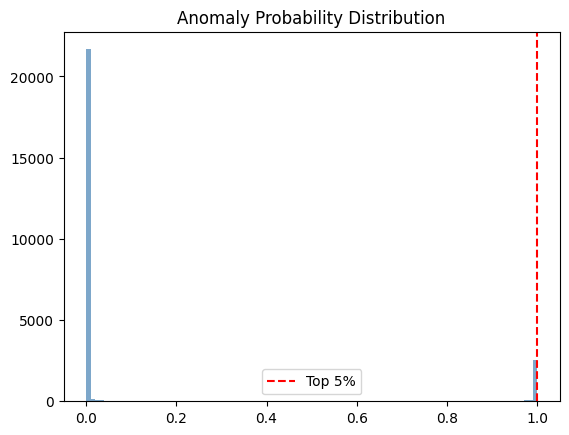

In [ ]:
plt.hist(p_anom, bins=100, color="steelblue", alpha=0.7)
plt.axvline(np.quantile(p_anom, 0.93), color="red", linestyle="--", label="Top 5%")
plt.title("Anomaly Probability Distribution")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

for rate in [0.03, 0.04, 0.05, 0.06, 0.07 , 0.08, 0.09, 0.10]:
    k = int(rate * len(p_anom))
    pred = np.zeros(len(p_anom))
    pred[np.argsort(-p_anom)[:k]] = 1
    sil = silhouette_score(Xs, pred)
    ch = calinski_harabasz_score(Xs, pred)
    print(f"Rate={rate:.2f} → Silhouette={sil:.4f}, CH={ch:.2f}")


Rate=0.03 → Silhouette=0.3291, CH=79.24
Rate=0.04 → Silhouette=0.2308, CH=50.70
Rate=0.05 → Silhouette=0.1982, CH=43.31
Rate=0.06 → Silhouette=0.1461, CH=34.35
Rate=0.07 → Silhouette=0.0937, CH=24.10
Rate=0.08 → Silhouette=0.0467, CH=16.33
Rate=0.09 → Silhouette=0.0535, CH=20.49
Rate=0.10 → Silhouette=0.0545, CH=17.08


In [ ]:
q = np.quantile(p_anom, [0.90, 0.95, 0.97, 0.99, 0.995])
for p, v in zip([90,95,97,99,99.5], q):
    print(f"{p:>5}% quantile = {v:.4f}")


   90% quantile = 0.9875
   95% quantile = 1.0000
   97% quantile = 1.0000
   99% quantile = 1.0000
 99.5% quantile = 1.0000


In [ ]:
# task5 Tune — AE Ensemble + EarlyStop + Isotonic Calib + Multi Target Rate + Local Eval
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import fbeta_score, silhouette_score, calinski_harabasz_score

import torch
import torch.nn as nn
import torch.utils.data as data

# ----------------- Helpers -----------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = np.radians(lat1), np.radians(lat2)
    dlat = p2 - p1
    dlon = np.radians(lon2) - np.radians(lon1)
    a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(np.maximum(a, 0.0)))

def add_trend_feats(df, base):
    cols = [f"{base}_{i}" for i in [1,2,3,4] if f"{base}_{i}" in df.columns]
    if len(cols) < 2: return df
    x = df[cols].astype(float)
    df[f"{base}_mean"] = x.mean(axis=1)
    df[f"{base}_std"]  = x.std(axis=1)
    df[f"{base}_cv"]   = (df[f"{base}_std"]/(x.mean(axis=1).abs()+1e-6))
    df[f"{base}_delta14"] = x[cols[-1]] - x[cols[0]]
    t = np.arange(1, len(cols)+1, dtype=float)
    t_c = t - t.mean()
    df[f"{base}_slope"] = np.sum(x.values*t_c, axis=1) / (np.sum(t_c**2) + 1e-6)
    # max jump
    jumps = []
    for i in range(len(cols)-1):
        jumps.append((x[cols[i+1]] - x[cols[i]]).abs())
    if jumps:
        df[f"{base}_max_jump"] = pd.concat(jumps, axis=1).max(axis=1)
    return df

def add_geo_feats(df):
    for i in [1,2,3]:
        la1, lo1, la2, lo2 = f"login_lat_{i}", f"login_lon_{i}", f"login_lat_{i+1}", f"login_lon_{i+1}"
        if all(c in df.columns for c in [la1,lo1,la2,lo2]):
            df[f"login_dist_{i}{i+1}"] = haversine(df[la1], df[lo1], df[la2], df[lo2])
    dcols = [c for c in df.columns if c.startswith("login_dist_")]
    if dcols:
        df["login_dist_max"] = df[dcols].max(axis=1)
        df["login_dist_sum"] = df[dcols].sum(axis=1)
    return df

def winsorize_df(df, p=0.01):
    out = df.copy()
    for c in out.columns:
        if pd.api.types.is_numeric_dtype(out[c]):
            lo, hi = out[c].quantile(p), out[c].quantile(1-p)
            out[c] = out[c].clip(lo, hi)
    return out

def rankify(a): return pd.Series(a).rank(method="average").values

def normalize(arr):
    arr = np.asarray(arr, float)
    return (arr - arr.mean()) / (arr.std() + 1e-9)

def soft_threshold_probs(p, rate, sharpness=25):
    """Map p -> soft probability around the quantile threshold (1-rate)."""
    thr = np.quantile(p, 1 - rate)
    return 1.0 / (1.0 + np.exp(-sharpness * (p - thr)))

# ----------------- Paths -----------------
ROOT = Path(".")
TASK_DIR = ROOT / "task5"
TEST_PATH = TASK_DIR / "test.csv"
OUT_DIR = TASK_DIR / "submissionsTune"
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ----------------- Load -----------------
df = pd.read_csv(TEST_PATH)
assert "id" in df.columns, "ต้องมีคอลัมน์ id ใน test.csv"
id_vals = df["id"].astype(str).values

drop_cols = [c for c in ["id", "player_id"] if c in df.columns]
X = df.drop(columns=drop_cols, errors="ignore").copy()

for c in X.columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

# ----------------- Feature Eng -----------------
bases = {c[:-2] for c in X.columns if c.endswith(("_1","_2","_3","_4"))}
for b in bases: X = add_trend_feats(X, b)
X = add_geo_feats(X)

# fill / clean
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))
X = winsorize_df(X, p=0.01)

scaler = RobustScaler()
Xs = scaler.fit_transform(X.values)

# ----------------- Classical Models -----------------
IF = IsolationForest(n_estimators=700, max_samples="auto", bootstrap=True,
                     random_state=42, n_jobs=-1, contamination="auto")
IF.fit(Xs); s_if = -IF.score_samples(Xs)

OC = OneClassSVM(kernel="rbf", gamma="scale", nu=0.05)
OC.fit(Xs); s_oc = -OC.score_samples(Xs)

LOF = LocalOutlierFactor(n_neighbors=35, contamination=0.05, novelty=True)
LOF.fit(Xs); s_lof = -LOF.score_samples(Xs)

# ----------------- Autoencoder -----------------
class AE(nn.Module):
    def __init__(self, in_dim, h=128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_dim, h), nn.ReLU(),
            nn.Linear(h, h//2), nn.ReLU(),
        )
        self.dec = nn.Sequential(
            nn.Linear(h//2, h), nn.ReLU(),
            nn.Linear(h, in_dim)
        )
    def forward(self, x): return self.dec(self.enc(x))

device = "cuda" if torch.cuda.is_available() else "cpu"
in_dim = Xs.shape[1]
ae = AE(in_dim).to(device)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
crit = nn.MSELoss()
loader = data.DataLoader(torch.tensor(Xs, dtype=torch.float32),
                         batch_size=256, shuffle=True)

best_loss = float("inf"); patience = 3; wait = 0
for epoch in range(20):  # up to 20 epochs with early stop
    ae.train(); total = 0.0
    for batch in loader:
        batch = batch.to(device)
        opt.zero_grad()
        out = ae(batch)
        loss = crit(out, batch)
        loss.backward(); opt.step()
        total += loss.item()
    avg = total / max(1, len(loader))
    print(f"AE epoch {epoch+1}: loss={avg:.5f}")
    if avg < best_loss - 1e-3:
        best_loss = avg; wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("AE early stopping.")
            break

ae.eval()
with torch.no_grad():
    tX = torch.tensor(Xs, dtype=torch.float32).to(device)
    recon = ae(tX)
    rec_err = ((recon - tX)**2).mean(dim=1).cpu().numpy()
# min-max normalize AE error → score_ae
score_ae = (rec_err - rec_err.min()) / (rec_err.max() - rec_err.min() + 1e-9)

# ----------------- Rank Ensemble (with normalization) -----------------
r_if  = rankify(normalize(s_if))
r_oc  = rankify(normalize(s_oc))
r_lof = rankify(normalize(s_lof))
r_ae  = rankify(normalize(score_ae))
score_ens = (r_if + r_oc + r_lof + r_ae) / 4.0

# ----------------- Calibration (Isotonic if enough pseudo-labels) -----------------
# สร้าง pseudo labels: top 5% = anomaly(1), bottom 75% = normal(0)
q_hi, q_lo = 0.05, 0.75
hi_thr = np.quantile(score_ens, 1.0 - q_hi)
lo_thr = np.quantile(score_ens, q_lo)
pseudo_y = np.full(len(score_ens), np.nan)
pseudo_y[score_ens >= hi_thr] = 1
pseudo_y[score_ens <= lo_thr] = 0
mask = ~np.isnan(pseudo_y)

if mask.sum() > 200:
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(score_ens[mask], pseudo_y[mask])
    p_anom = iso.predict(score_ens)
else:
    # fallback: linear min-max
    mn, mx = score_ens.min(), score_ens.max()
    p_anom = (score_ens - mn) / (mx - mn + 1e-9)

# ----------------- Multiple target rates + Local evaluation -----------------
target_rates = [0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
order = np.argsort(-p_anom)

# pseudo ground truth (only for local eval): top 5% of ensemble = anomaly
y_pseudo_all = (score_ens >= np.quantile(score_ens, 0.95)).astype(int)

print("\n=== Local Pseudo-F3 / Silhouette / CH per target_rate ===")
for rate in target_rates:
    # soft probability around the threshold (optional): switch to hard by using (p_anom >= thr)
    pred_prob = soft_threshold_probs(p_anom, rate, sharpness=25)
    pred = (pred_prob >= 0.5).astype(int)

    # local pseudo-F3
    f3 = fbeta_score(y_pseudo_all, pred, beta=3)

    # cluster separation on scaled features
    try:
        sil = silhouette_score(Xs, pred)
        ch  = calinski_harabasz_score(Xs, pred)
    except Exception:
        sil, ch = np.nan, np.nan

    print(f"rate={rate:.2f} → pseudo-F3={f3:.4f} | Sil={sil:.4f} | CH={ch:.2f}")

    # write submission
    sub = pd.DataFrame({"id": id_vals, "task5": pred})
    OUT_FILE = OUT_DIR / f"task5_pred_rate{int(rate*100):02d}.csv"
    sub.to_csv(OUT_FILE, index=False)
    print(f"[OK] wrote {OUT_FILE} (anomaly_rate={pred.mean():.4f}, n={len(pred)})")


C:\Users\Admin\AppData\Local\Temp\ipykernel_23948\2100757473.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base}_delta14"] = x[cols[-1]] - x[cols[0]]
C:\Users\Admin\AppData\Local\Temp\ipykernel_23948\2100757473.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base}_slope"] = np.sum(x.values*t_c, axis=1) / (np.sum(t_c**2) + 1e-6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23948\2100757473.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

AE epoch 1: loss=101171118.71055
AE epoch 2: loss=70113.87218
AE epoch 3: loss=4827.76707
AE epoch 4: loss=6130.94031
AE epoch 5: loss=6348.04883
AE epoch 6: loss=49742.57036
AE early stopping.

=== Local Pseudo-F3 / Silhouette / CH per target_rate ===
rate=0.03 → pseudo-F3=1.0000 | Sil=0.6121 | CH=2211.81
[OK] wrote task5\submissionsTune\task5_pred_rate03.csv (anomaly_rate=0.0500, n=25889)
rate=0.04 → pseudo-F3=1.0000 | Sil=0.6121 | CH=2211.81
[OK] wrote task5\submissionsTune\task5_pred_rate04.csv (anomaly_rate=0.0500, n=25889)
rate=0.05 → pseudo-F3=1.0000 | Sil=0.6121 | CH=2211.81
[OK] wrote task5\submissionsTune\task5_pred_rate05.csv (anomaly_rate=0.0500, n=25889)
rate=0.06 → pseudo-F3=0.9803 | Sil=0.5888 | CH=2194.63
[OK] wrote task5\submissionsTune\task5_pred_rate06.csv (anomaly_rate=0.0601, n=25889)
rate=0.07 → pseudo-F3=0.9615 | Sil=0.5722 | CH=2297.83
[OK] wrote task5\submissionsTune\task5_pred_rate07.csv (anomaly_rate=0.0700, n=25889)
rate=0.08 → pseudo-F3=0.9433 | Sil=0.5465 